<a href="https://colab.research.google.com/github/ulissigroup/Physics-Enabled-AL-MLP/blob/master/figure_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@al_dev
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q git+https://mshuaibi@bitbucket.org/andrewpeterson/amp.git
!pip install -q --upgrade dftbook

import dftbook
dftbook.setup_colab()

     |████████████████████████████████| 296kB 8.9MB/s 
     |████████████████████████████████| 6.7MB 27.1MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 2.1MB 54.3MB/s 
     |████████████████████████████████| 12.8MB 254kB/s 
     |████████████████████████████████| 110.5MB 37kB/s 
     |████████████████████████████████| 512kB 48.9MB/s 
     |████████████████████████████████| 3.8MB 54.5MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ...

In [0]:
import ase
import time
import sys
import copy

from amp.descriptor.gaussian import Gaussian
from amptorch.gaussian import SNN_Gaussian
from amptorch.model import BPNN, CustomMSELoss
from amptorch.data_preprocess import AtomsDataset, collate_amp
from amptorch.skorch_model import AMP
from amptorch.skorch_model.utils import target_extractor, energy_score, forces_score
from amptorch.delta_models.morse import morse_potential

import torch

import numpy as np
from ase import Atoms, units
from ase.calculators.emt import EMT
import seaborn as sns
from ase.calculators.singlepoint import SinglePointCalculator as sp

import skorch.callbacks.base
from skorch.utils import to_numpy
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# define symmetry functions to be used
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 10.0 #EMT asap_cutoff: False

In [0]:
from espresso import Espresso
import ase.io
# Define Training data
energies = []
forces = []
distances = np.linspace(1, 5, 30)
images = []

calc = Espresso(pw=500.0,
                calculation='scf',
                xc='PBE')

label = "bond_example"
for displacement in distances:
    atoms = Atoms("CuCu", [(0, 0, 0), (0, 0, displacement)])
    atoms.set_cell([10, 10, 10])
    atoms.center()
    atoms.set_calculator(copy.deepcopy(calc))
    energy = atoms.get_potential_energy(apply_constraint=False)
    forces = atoms.get_forces(apply_constraint=False)
    atoms.set_calculator(sp(atoms, energy=energy, forces=forces))
    energies.append(energy)
    forces.append(forces)
    images.append(atoms)

ase.io.write("cu_bond.traj", images)
energies = np.array(energies)
forces = np.concatenate(np.array(forces))
distances = np.array(distances)

In [0]:
# Limited dataset
images = ase.io.read("cu_bond.traj", ":")
distances = np.linspace(1,5,30)
energies = np.array([image.get_potential_energy() for image in images])
energies -= energies[-1]
training_small = np.array([7, 8, 9])
training_images_small = [images[i] for i in training_small]
training_energies_small = energies[training_small]
training_distances_small = distances[training_small]

# Diverse dataset
training_large = np.array([1, 5, 7, 9, 11, 14, 24, 25, 28])
training_images_large = [images[i] for i in training_large]
training_energies_large = energies[training_large]
training_distances_large = distances[training_large]

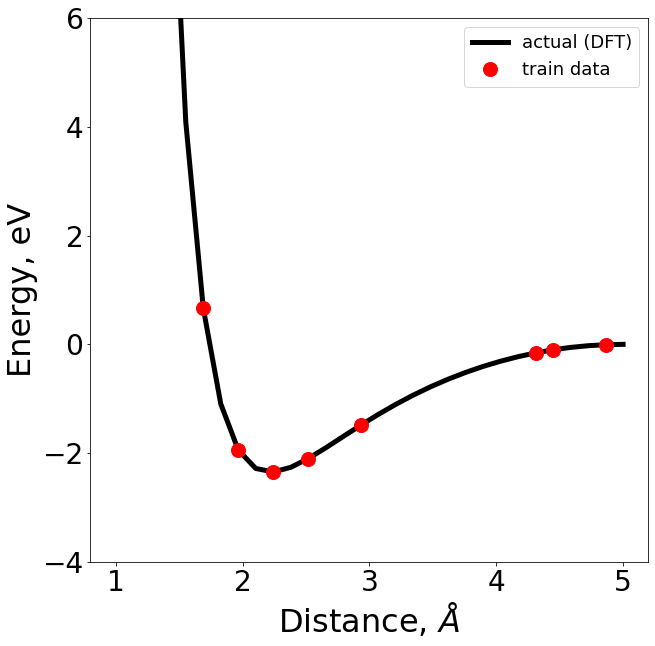

In [0]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=5, label="actual (DFT)")
ax1.plot(training_distances_large, training_energies_large, "ro", label="train data", markersize=14)
ax1.set_ylim(top=6)
ax1.set_ylim(bottom=-4)
ax1.tick_params(axis="both", labelsize=28)
plt.legend(fontsize=18)

In [0]:
def train(training_images, test_images, label, morse=False):
    morse_data = None
    if morse:
        morse_model = morse_potential(training_images, Gs["cutoff"], label, combo="mean")
        morse_energies, morse_forces, num_atoms = morse_model.morse_pred(training_images)
        morse_data = [morse_energies, morse_forces, num_atoms, morse_model]

    forcetraining = True
    training_data = AtomsDataset(
        training_images,
        SNN_Gaussian,
        Gs,
        forcetraining=forcetraining,
        label=label,
        cores=1,
        delta_data=morse_data,
    )
    unique_atoms = training_data.elements
    fp_length = training_data.fp_length
    device = "cpu"

    net = NeuralNetRegressor(
        module=BPNN(
            unique_atoms, [fp_length, 3, 5], device, forcetraining=forcetraining
        ),
        criterion=CustomMSELoss,
        criterion__force_coefficient=0.04,
        optimizer=torch.optim.LBFGS,
        optimizer__line_search_fn="strong_wolfe",
        lr=1e-2,
        batch_size=len(training_data),
        max_epochs=100,
        iterator_train__collate_fn=collate_amp,
        iterator_train__shuffle=False,
        iterator_valid__collate_fn=collate_amp,
        device=device,
        train_split=0,
        callbacks=[
            EpochScoring(
                forces_score,
                on_train=True,
                use_caching=True,
                target_extractor=target_extractor,
            ),
            EpochScoring(
                energy_score,
                on_train=True,
                use_caching=True,
                target_extractor=target_extractor,
            ),
        ],
    )
    calc = AMP(training_data, net, label)
    calc.train(overwrite=True)

    ml_delta_e_pred = [calc.get_potential_energy(image) for image in test_images]
    ml_delta_f_pred = [calc.get_forces(image) for image in test_images]
    
    return ml_delta_e_pred, ml_delta_f_pred

In [0]:
# ML large data spread
ml_pred_large, ml_forces_large = train(training_images_large, copy.deepcopy(images), label="bond_large", morse=False)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          8.3156         42.3554       10.6463  0.3039
      2          3.7703         15.6627        1.8154  0.0733


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


      3          0.9494          4.5695        0.1312  0.0761
      4          0.0337          0.1693        0.0002  0.0834
      5          0.0345          0.1615        0.0002  0.0956
      6          0.0351          0.1559        0.0002  0.0720
      7          0.0355          0.1466        0.0002  0.0763
      8          0.0344          0.1470        0.0002  0.0798
      9          0.0251          0.1061        0.0001  0.0834
     10          0.0217          0.0732        0.0001  0.0788
     11          0.0203          0.0656        0.0000  0.1137
     12          0.0200          0.0655        0.0000  0.1140
     13          0.0198          0.0651        0.0000  0.0799
     14          0.0182          0.0629        0.0000  0.0884
     15          0.0166          0.0680        0.0000  0.0725
     16          0.0164          0.0687        0.0000  0.0217
     17          0.0164          0.0687        0.0000  0.0206
     18          0.0164          0.0687        0.0000  0.0220
     19 

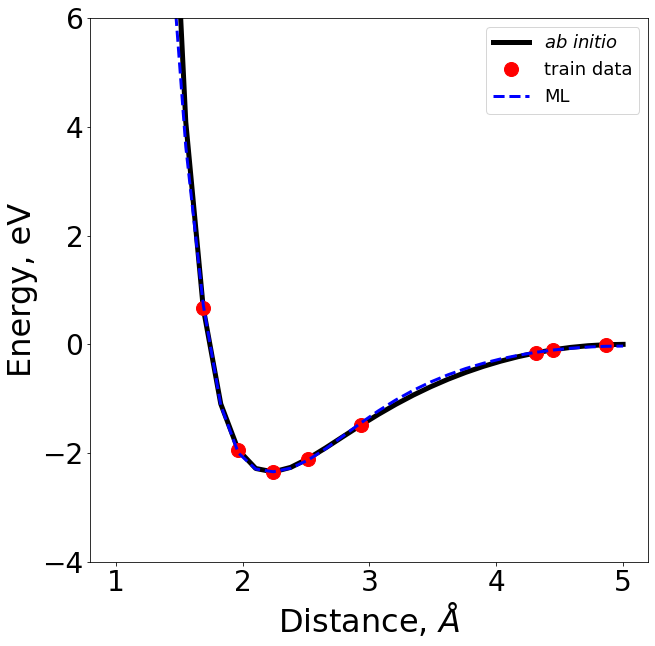

In [0]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=5, label="$ab\ initio$")
ax1.plot(training_distances_large, training_energies_large, "ro", label="train data", markersize=14)
ax1.plot(distances, ml_pred_large, color="blue", ls='--', linewidth=3, label="ML")
ax1.tick_params(axis="both", labelsize=28)
ax1.set_ylim(top=6)
ax1.set_ylim(bottom=-4)
plt.legend(fontsize=18)
plt.savefig('large_data.png', dpi=300)

In [0]:
# ML limited data spread
ml_pred_small, ml_forces_small = train(training_images_small, images, label="bond_small", morse=False)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.0894          1.3505       10.2796  0.0773
      2          0.0322          0.1566        0.2564  0.0639
      3          0.0104          0.0624        0.0335  0.0626
      4          0.0061          0.0120        0.0054  0.0653
      5          0.0022          0.0047        0.0007  0.0619
      6          0.0010          0.0038        0.0002  0.0719
      7          0.0006          0.0013        0.0000  0.0650
      8          0.0002          0.0007        0.0000  0.0722
      9          0.0001          0.0003        0.0000  0.0756
     10          0.0001          0.0001        0.0000  0.0729
     11          0.0000          0.0001        0.0000  0.0725
     12          0.0000          0.0000        0.0000  0.0113
     13          0.0000          0.0000        0.0000  0.0127
     14          

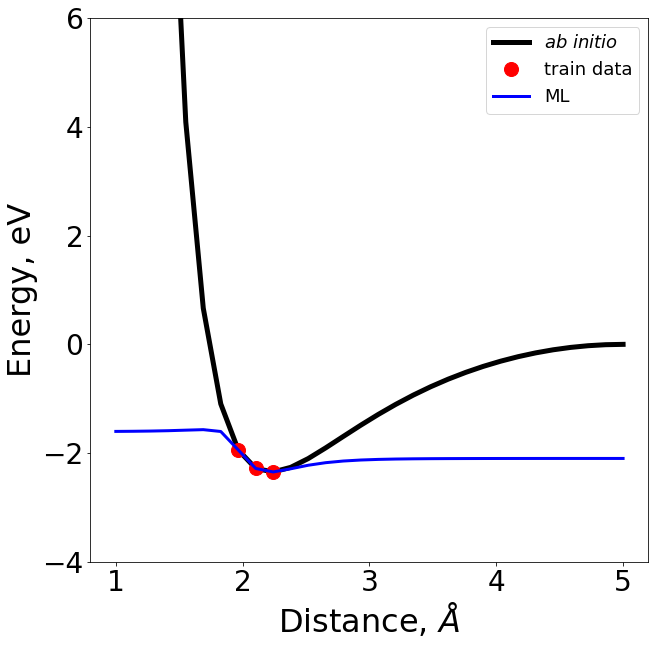

In [0]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=5, label="$ab\ initio$")
ax1.plot(training_distances_small, training_energies_small, "ro", label="train data", markersize=14)
ax1.plot(distances, ml_pred_small, color="blue", ls='-', linewidth=3, label="ML")
# ax1.plot(distances, ml_forces_small)
ax1.tick_params(axis="both", labelsize=28)
plt.legend(fontsize=18)
ax1.set_ylim(bottom=-4)
ax1.set_ylim(top=6)
plt.savefig('small_data.png', dpi=300)

In [0]:
# ML limited data spread with Morse
ml_pred_small_morse, ml_forces_small_morse = train(training_images_small, images, label="bond_small_morse", morse=True)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.0177          0.2273        8.2873  0.0956
      2          0.0023          0.0230        0.0924  0.0823
      3          0.0018          0.0081        0.0204  0.0728
      4          0.0012          0.0026        0.0056  0.0670
      5          0.0007          0.0011        0.0019  0.0783
      6          0.0004          0.0011        0.0009  0.0668
      7          0.0004          0.0011        0.0007  0.0781
      8          0.0002          0.0010        0.0004  0.0685
      9          0.0002          0.0004        0.0001  0.0705
     10          0.0002          0.0004        0.0001  0.0761
     11          0.0002          0.0003        0.0001  0.0802
     12          0.0001          0.0003        0.0001  0.0778
     13          0.0001          0.0003        0.0000  0.1054
     14          

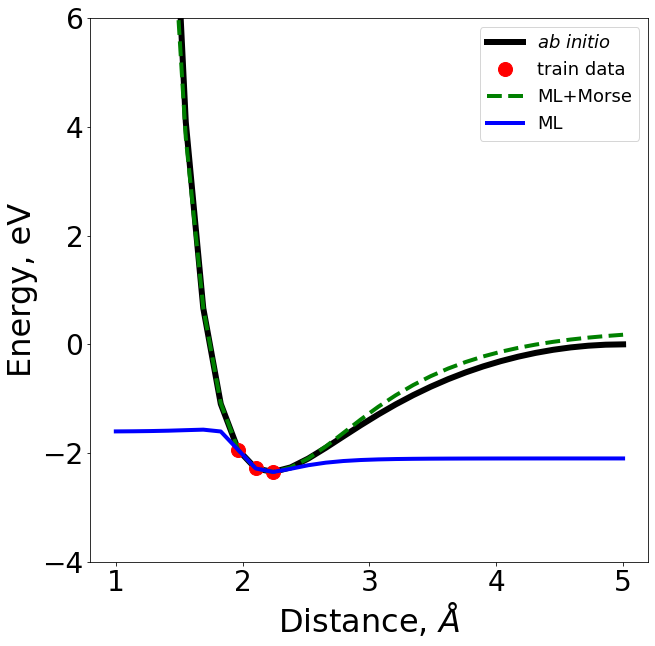

In [0]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=6, label="$ab\ initio$")
ax1.plot(training_distances_small, training_energies_small, "ro", label="train data", markersize=14)
ax1.plot(distances, ml_pred_small_morse, color="g", ls='--', linewidth=4, label="ML+Morse")
ax1.plot(distances, ml_pred_small, color="blue", ls='-', linewidth=4, label="ML")
ax1.tick_params(axis="both", labelsize=28)
ax1.set_ylim(top=6)
ax1.set_ylim(bottom=-4)
plt.legend(fontsize=18)
plt.savefig('small_data_morse.png', dpi=300)